In [1]:
import random
from random import sample
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
from fast_ixi import FAST_IXI
from utils import read_config

In [2]:
# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device: {}'.format(device))

Device: cuda


In [3]:
opt = read_config('config.yaml')
opt

{'dataset': {'class_names': ['absent_sentum',
   'artefacts',
   'craniatomy',
   'dural',
   'ea_mass',
   'edema',
   'encephalo',
   'extra_axial'],
  'path': '/home/mamur/TUM/Seminar/dataset',
  'resize': 128,
  'cropsize': 128,
  'batch_size': 1},
 'model': {'backbone': 'wide_resnet50_2'}}

In [4]:
save_dir = './results/' + opt['model']['backbone']

## pre-trained CNN

In [5]:
if opt['model']['backbone'] == 'resnet18':
    model = resnet18(pretrained=True, progress=True)
    t_d = 448
    d = 180

elif opt['model']['backbone'] == 'wide_resnet50_2':
    model = wide_resnet50_2(pretrained=True, progress=True)
    t_d = 1792
    d = 550

else:
    raise NotImplementedError

/home/mamur/miniconda3/envs/adlm/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mamur/miniconda3/envs/adlm/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
print('Backbone: {}'.format(opt['model']['backbone']))
print('Input dim size: {}'.format(t_d))
print('Output dim size after reduced: {}'.format(d))

Backbone: wide_resnet50_2
Input dim size: 1792
Output dim size after reduced: 550


In [7]:
model.to(device)
model.eval()
random.seed(1024)
torch.manual_seed(1024)
torch.cuda.manual_seed_all(1024)

In [8]:
# select randomly choosen dimension to reduce the dimensionality of the feature vector (like PCA)
idx = torch.tensor(sample(range(0, t_d), d))
# set model's intermediate outputs


In [9]:
outputs = []
def hook(module, input, output):
    outputs.append(output)
model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)

In [10]:
# create path to save the results if not exists
os.makedirs(os.path.join(save_dir, 'temp_%s' % opt['model']['backbone']), exist_ok=True)
train_feature_filepath = os.path.join(save_dir, 'temp_%s' % opt['model']['backbone'], 'train_%s.pkl' % 'brainmri')

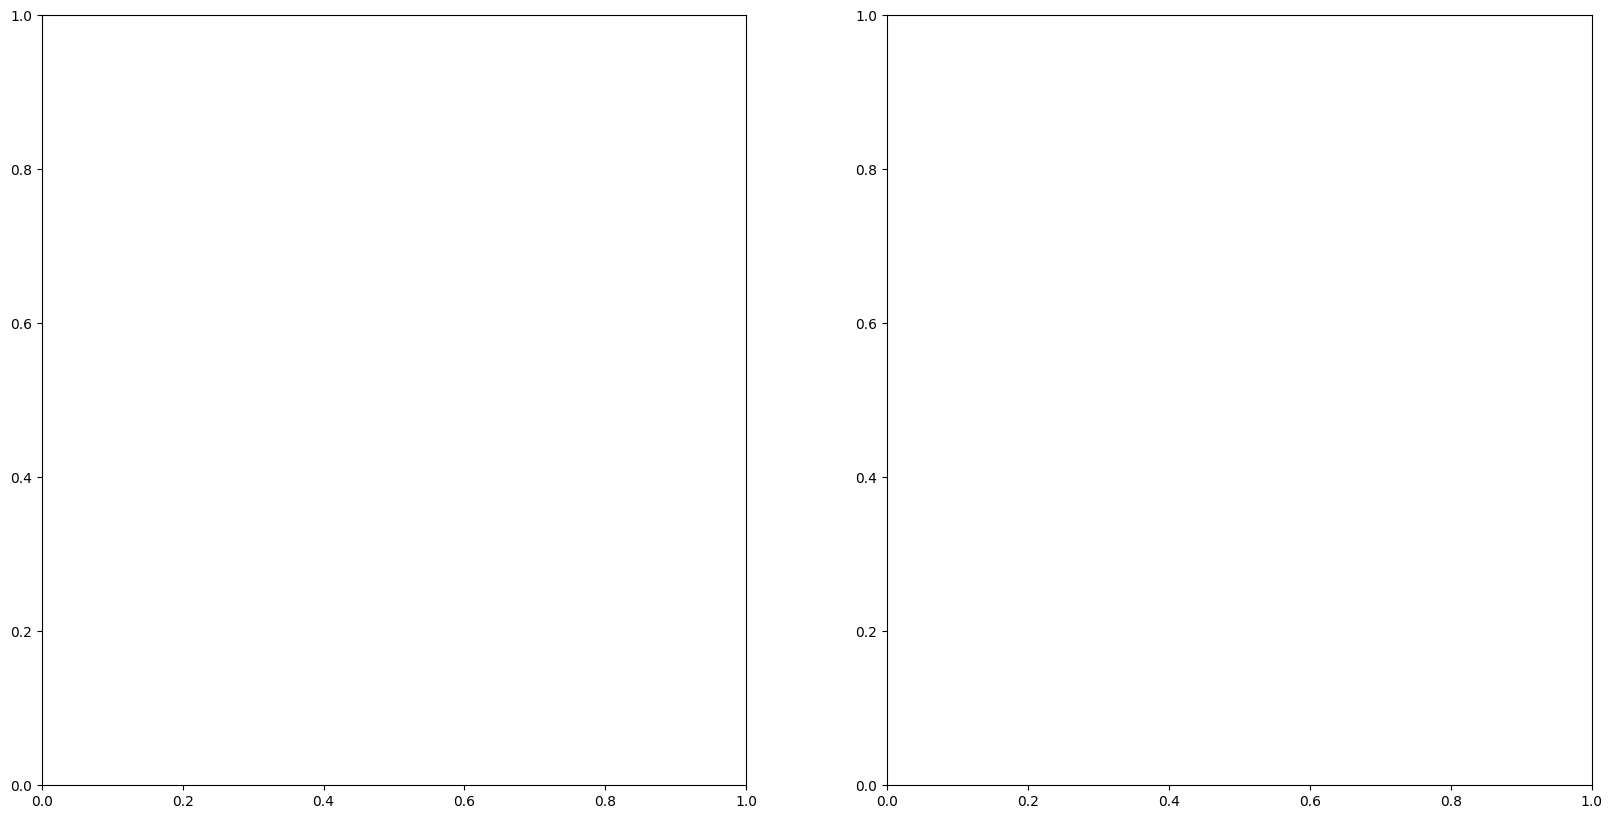

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig_img_rocauc = ax[0]
fig_pixel_rocauc = ax[1]
total_roc_auc = []
total_pixel_roc_auc = []

## Load Dataset

In [12]:
# load dataset

train_dataset = FAST_IXI(opt, is_train=True)
train_dataloader = DataLoader(train_dataset, batch_size=opt['dataset']['batch_size'], pin_memory=True)

test_dataset = FAST_IXI(opt, is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=opt['dataset']['batch_size'], pin_memory=True)

train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

In [13]:
print('train size:', len(train_dataloader))
print('test_size:', len(test_dataloader))

train size: 711
test_size: 111


## Normal Class Representation

In [14]:
def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z

In [15]:
train_outputs

OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

In [16]:
# extract features from each layer of the pretrained model

In [17]:
# TODO : Make optional to extract feature method (read from the file or extract from the model)

In [18]:
if not os.path.exists(train_feature_filepath):
    print('train feature extraction')
    for (img, label, mask) in tqdm(train_dataloader, '| feature extraction | train | %s |' % 'brainmri'):
        img = img.to(device)
        with torch.no_grad():
            _ = model(img)
        for key, value in zip(train_outputs.keys(), outputs):
            train_outputs[key].append(value.cpu().detach())
        # initialize hook outputs
        outputs = []        
    for key, value in train_outputs.items():
        train_outputs[key] = torch.cat(value, 0)

    print('first layer shape:', train_outputs['layer1'].shape)
    print('second layer shape:', train_outputs['layer2'].shape)
    print('third layer shape:', train_outputs['layer3'].shape)

    # Embedding concat
    embedding_vectors = train_outputs['layer1'] # get the maximum size of the embedding vectors
   
    """
    Rresearchers conceptually divide the input image into a grid based on the resolution of the largest activation map—typically
    the first layer of the pre-trained CNN. This way, each grid position, denoted as (i,j), 
    is associated with a unique embedding vector that represents the collective activation vectors for that particular image patch.
    """
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

    # randomly select d dimension
    print('randomly select %d dimension' % d)
    embedding_vectors = torch.index_select(embedding_vectors, 1, idx)

    B, C, H, W = embedding_vectors.size() # Get the shape of the embedding vectors which is same with the first layer of the pretrained model
    print('embedding_vectors shape:', embedding_vectors.shape)
    embedding_vectors = embedding_vectors.view(B, C, H * W)

    # calculate multivariate Gaussian distribution
    mean = torch.mean(embedding_vectors, dim=0).numpy()
    cov = torch.zeros(C, C, H * W).numpy()
    I = np.identity(C)

    # calculate mean, cov and inverse covariance matrix for each patch position at Xij 
    # (each patch position (i,j) is associated with a unique embedding vector)
    for i in range(H * W):
        # Xij = embedding_vectors[:, :, i].numpy()
        cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I

    # save learned distribution
    train_outputs = [mean, cov]
    with open(train_feature_filepath, 'wb') as f:
        pickle.dump(train_outputs, f)
else:
    # load train set features
    with open(train_feature_filepath, 'rb') as f:
        train_outputs = pickle.load(f)

train feature extraction


| feature extraction | train | brainmri |: 100%|██████████| 711/711 [00:10<00:00, 69.45it/s]


first layer shape: torch.Size([711, 256, 32, 32])
second layer shape: torch.Size([711, 512, 16, 16])
third layer shape: torch.Size([711, 1024, 8, 8])


: 

## PaDiM at Inference Time

In [18]:
gt_list = []
gt_mask_list = []
test_imgs = []

In [19]:
# extract test set features
for (img, label, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % 'brainmri'):
    test_imgs.extend(img.cpu().detach().numpy())
    gt_list.extend(label.cpu().detach().numpy())
    gt_mask_list.extend(mask.cpu().detach().numpy())

    # get the model prediction
    with torch.no_grad():
        _ = model(img.to(device))
    
    # get intermediate outputs
    for key, value in zip(test_outputs.keys(), outputs):
        test_outputs[key].append(value.cpu().detach())

    # initialize hook outputs
    outputs = []

for key, value in test_outputs.items():
    test_outputs[key] = torch.cat(value, 0)

print('first layer shape:', test_outputs['layer1'].shape)
print('second layer shape:', test_outputs['layer2'].shape)
print('third layer shape:', test_outputs['layer3'].shape)

# Embedding concat
embedding_vectors = test_outputs['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

# randomly select d dimension
embedding_vectors = torch.index_select(embedding_vectors, 1, idx)

| feature extraction | test | brainmri |: 100%|██████████| 111/111 [00:00<00:00, 111.03it/s]


first layer shape: torch.Size([111, 64, 32, 32])
second layer shape: torch.Size([111, 128, 16, 16])
third layer shape: torch.Size([111, 256, 8, 8])


In [20]:
# calculate mahalanobis distance between train_outputs to give anomaly score to each patch position of the test images
B, C, H, W = embedding_vectors.size()
print('embedding_vectors shape:', embedding_vectors.shape)

embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
dist_list = []
for i in range(H * W):
    mean = train_outputs[0][:, i]
    conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
    dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
    dist_list.append(dist)
dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)

embedding_vectors shape: torch.Size([111, 180, 32, 32])


In [21]:
# upsample to image size to get anomaly score map
dist_list = torch.tensor(dist_list)
score_map = F.interpolate(dist_list.unsqueeze(1), size=img.size(2), mode='bilinear',
                            align_corners=False).squeeze().numpy()

# apply gaussian smoothing on the score map
for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4)

# Normalize the score map
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)

## Calculate Metrics

In [22]:
from utils import denormalization, plot_fig

In [23]:
# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
fpr, tpr, _ = roc_curve(gt_list, img_scores)
img_roc_auc = roc_auc_score(gt_list, img_scores)
total_roc_auc.append(img_roc_auc)
fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % ('brainmri', img_roc_auc))
print('image ROCAUC: %.3f' % (img_roc_auc))
        

image ROCAUC: 0.823


In [24]:
# get optimal threshold
gt_mask = np.asarray(gt_mask_list)
precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
a = 2 * precision * recall
b = precision + recall
f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
threshold = thresholds[np.argmax(f1)]
print('threshold: %.3f' % (threshold))

threshold: 0.283


In [25]:
# calculate per-pixel level ROCAUC
fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
total_pixel_roc_auc.append(per_pixel_rocauc)
print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

pixel ROCAUC: 0.882


In [26]:
fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % ('brainmri', per_pixel_rocauc))
save_dir = save_dir + '/pictures_' + opt['model']['backbone']
os.makedirs(save_dir, exist_ok=True)
plot_fig(test_imgs, scores, gt_mask_list, threshold, save_dir, 'brainmri')

In [27]:

print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
fig_img_rocauc.legend(loc="lower right")

print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
fig_pixel_rocauc.legend(loc="lower right")

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'roc_curve.png'), dpi=100)

Average ROCAUC: 0.823
Average pixel ROCUAC: 0.882
